# practice

If you don't have it yet, please <a href="/archive/data/jerusalem2019.csv" download>download here</a> the meteorological data fro 2019 in Jerusalem.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima_process import ArmaProcess
np.random.seed(49)

# %matplotlib widget

# White noise
If we randomly draw values from the same distribution we will get white noise.

In [2]:
# generate binary noise random ones and zeroes with equal distribution
n = 1000
binary_noise = np.random.choice([-1, 1], size=n)

# generate gaussian noise with mean 0 and standard deviation 1
gaussian_noise = np.random.normal(0, 1, n)

Text(0.5, 1.0, 'gaussian')

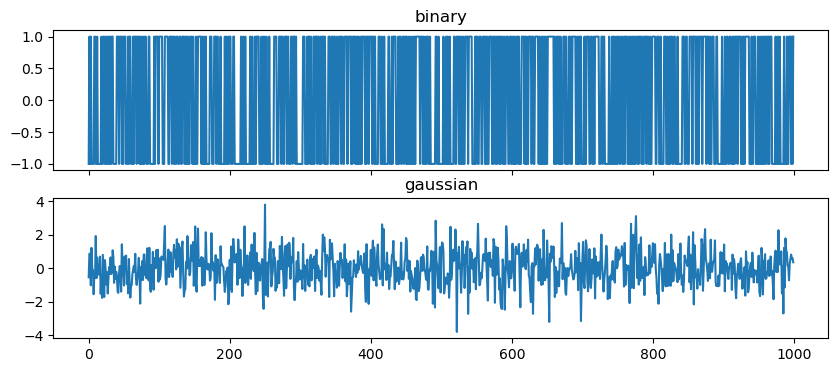

In [3]:
# plot:
fig, ax = plt.subplots(2,1, figsize=(10,4), sharex=True)
ax[0].plot(binary_noise)
ax[0].set_title('binary')

ax[1].plot(gaussian_noise)
ax[1].set_title('gaussian')

# Random walk
If we cumulatively sum the white noise, we then get a random walk

Text(0.5, 1.0, 'walk gaussian')

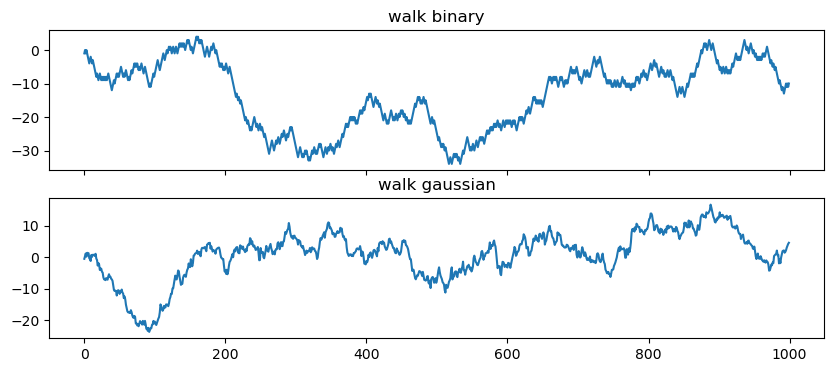

In [4]:
walk_binary = binary_noise.cumsum()
walk_gaussian = gaussian_noise.cumsum()

fig, ax = plt.subplots(2,1, figsize=(10,4), sharex=True)
ax[0].plot(walk_binary)
ax[0].set_title('walk binary')

ax[1].plot(walk_gaussian)
ax[1].set_title('walk gaussian')

## Differencing
Given an array  
$$a = [a_0, a_1, a_2, ..., a_{n-1}]$$ 
the operation performed by `np.diff(a)` can be represented as:  
$$\Delta a = [\Delta a_1, \Delta a_2, ..., \Delta a_{n-1}]$$ 
where  
$$\Delta a_i = a_{i} - a_{i-1} \quad \text{for} \quad i = 1, 2, ..., n-1$$  

**If we difference the random walk we will get the white noise.**

(0.0, 100.0)

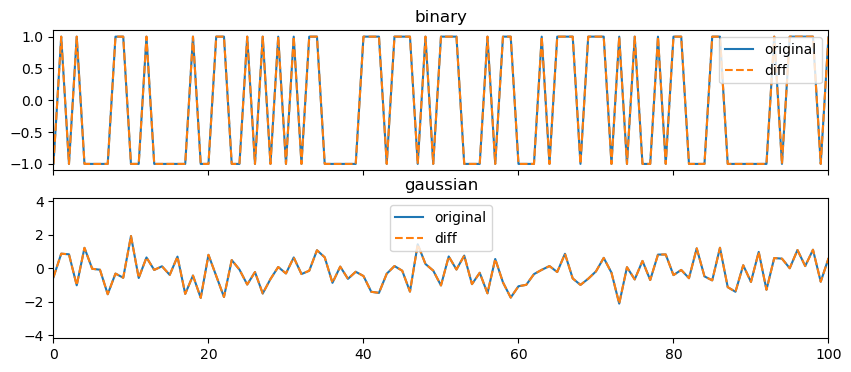

In [5]:
fig, ax = plt.subplots(2,1, figsize=(10,4), sharex=True)
ax[0].plot(binary_noise, label='original')
ax[0].plot(np.diff(walk_binary, prepend=0), label='diff', linestyle='--')
ax[0].set_title('binary')
ax[0].legend()
ax[0].set_xlim(0,100)

ax[1].plot(gaussian_noise, label='original')
ax[1].plot(np.diff(walk_gaussian, prepend=0), label='diff', linestyle='--')
ax[1].set_title('gaussian')
ax[1].legend()
ax[1].set_xlim(0,100)

Another way of understanding this: the python operations `cumsum` and `diff` are each other's inverse.

# AR(1)
$$
X_{t} = \phi\,X_{t-1} + \varepsilon.
$$

This is called an Autoregressive Process of order 1, or AR(1). Here, the current value $X_{t}$ is dependent on the immediately preceding value $X_{t-1}$.

Text(0.5, 1.0, 'AR(1)\t$\\Phi=0.9$')

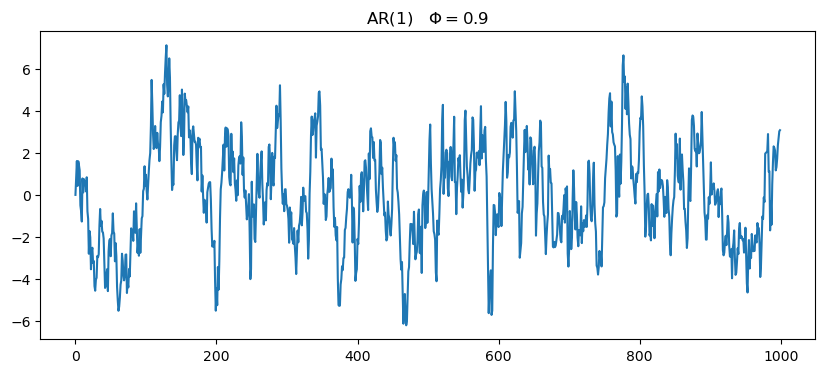

In [6]:
#  initialize time series array
ar1_series = np.zeros(n)

# set a phi value, in addition to this value you should try phi>1 or phi=0
phi = 0.9

for i in range(1, n):
    ar1_series[i] = phi*ar1_series[i-1] + gaussian_noise[i]

# plot:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(ar1_series)
ax.set_title(f'AR(1)\t$\Phi={phi}$')

## AR(p)

The next thing to do is to generalize, and define an autoregressive process that depends on $p$ previous states:

$$
x_{t} = \phi_1\,x_{t-1} + \phi_2\,x_{t-2} + \cdots + \phi_p\,x_{t-p} + \varepsilon
$$

In [7]:
# Function to generate AR(p) time series
# this function can recive p as an integer and then is will draw random phi values
# or, you can pass p as a np array of the specific phi values you want.
def generate_ar(n, p):
    # Check if p is an integer or an array
    if isinstance(p, int):
        # Generate random coefficients between -1 and 1
        phi = np.random.uniform(-1, 1, size=p)
    elif isinstance(p, np.ndarray):
        phi = p  # Use the provided array as coefficients
    else:
        raise ValueError("p should be either an integer or a NumPy array")
    
    print(phi)
    # Generate white noise
    noise = np.random.normal(0, 1, n)
    
    # Initialize time series array
    ar_series = np.zeros(n)
    
    for i in range(phi.size, n):
        ar_series[i] = np.dot(phi, ar_series[i-phi.size:i]) + noise[i]
    
    return ar_series

[-0.82679831 -0.50310415 -0.68089179  0.1555622 ]


Text(0.5, 1.0, 'AR(4)')

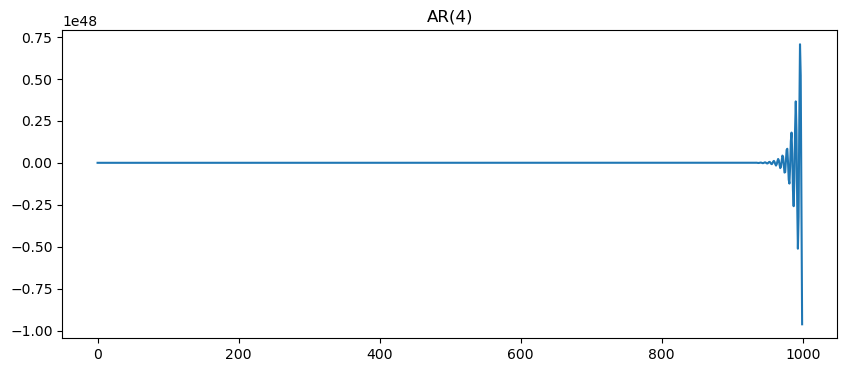

In [8]:
# plot using p as an int
p = 4
ar = generate_ar(n, p)
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(ar)
ax.set_title(f'AR({p})')

### using specific $\phi$ values
In the cell below we can specify specific $\phi$ values.  
Use the [interactive tool](https://yairmau.com/time-series/stationarity/stationarity.html#stationarity-of-ar2) from our website to chose the right values.  
Remember, if one of the roots is inside the unit circle, the series will be **not** stationary.


[-0.97 -1.88]


Text(0.5, 1.0, 'AR([-0.97 -1.88])')

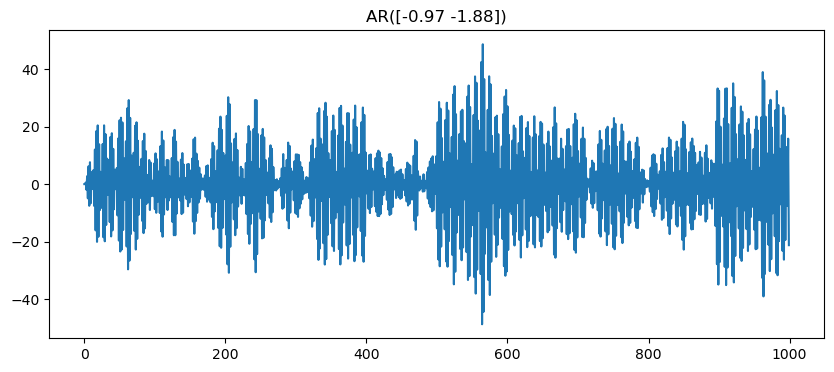

In [9]:
# plot using p as an array of phi values
# the order should be [phi2, phi1]
p = np.array([-0.97,-1.88])
# p = np.array([-1.88,-0.97])

ar2 = generate_ar(n, p)
fig, ax = plt.subplots(figsize=(10,4))

ax.plot(ar2)
ax.set_title(f'AR({p})')

### Weak stationarity
1. its mean $\mu$ does not vary in time:
   $$
   \mu_X(t) = \mu_X(t+\tau)
   $$
   for all values of $t$ and $\tau$.
1. its variance is finite for any time $t$:
   $$
   \sigma^2_X(t) < \infty.
   $$
1. The autocorrelation function between two lagged versions of the same time series, $X(t_1)$ and $X(t_2)$, depends only on the difference $\tau=t_2-t_1$.  
  
  
Let's get a feeling by plotting

In [10]:
def test_stationarity(time_series, window=100, yscale='linear'):
    series = pd.Series(time_series)
    rolling_var = series.rolling(window=window, center=True).std()**2
    rolling_mean = series.rolling(window=window, center=True).mean()

    fig, ax = plt.subplots(2,1, figsize=(10,4), sharex=True)
    ax[0].plot(series, label='series')
    ax[0].plot(rolling_mean, c='r', label='mean')
    ax[0].legend()
    ax[0].set_title('rolling mean')
    ax[0].set_yscale(yscale)

    ax[1].plot(rolling_var)
    ax[1].set_title('rolling variance')

    return

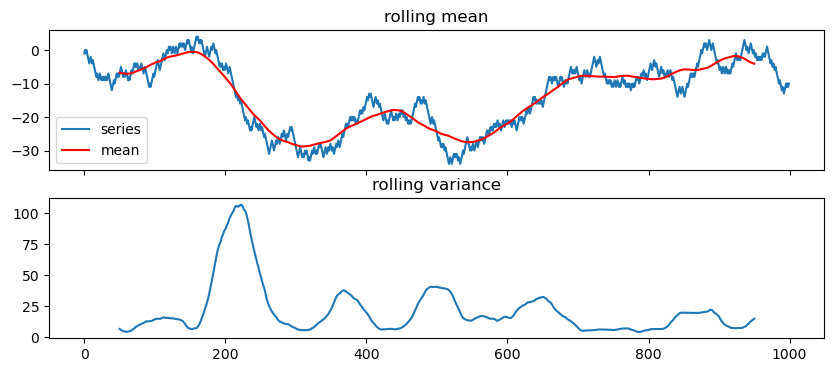

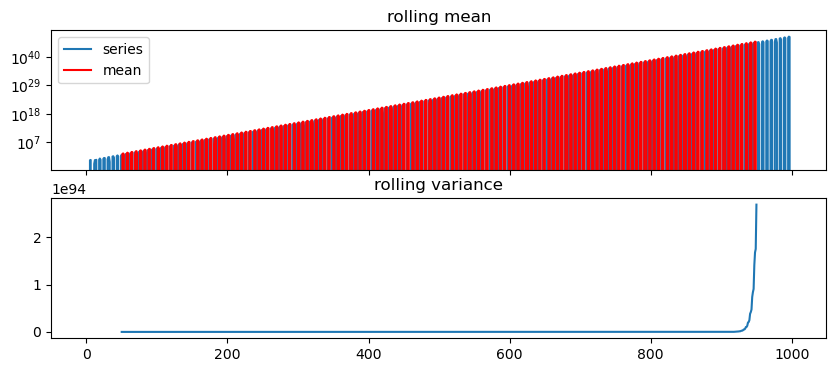

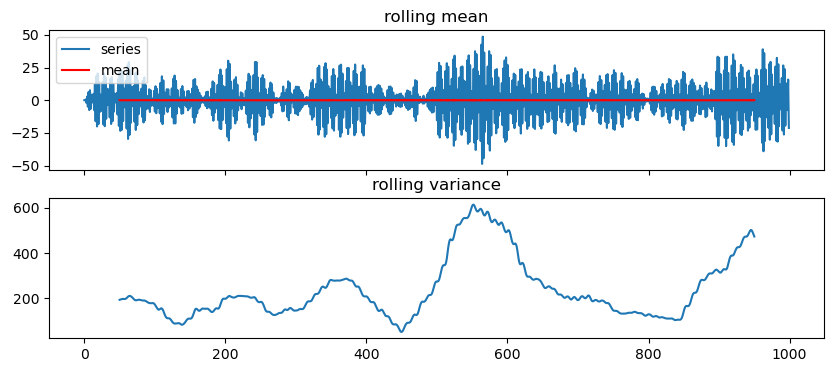

In [11]:
test_stationarity(walk_binary)
# test_stationarity(walk_gaussian)
# test_stationarity(ar1_series)
test_stationarity(ar, yscale='log')
test_stationarity(ar2)

# ACF

In [12]:
def compute_acf(series):
    N = len(series)
    lags = np.arange(N)
    acf = np.zeros_like(lags)
    series = (series - series.mean()) / series.std()
    for i in lags:
        acf[i] = np.sum(series[i:] * series[:N-i])
    acf = acf / N
    return lags, acf

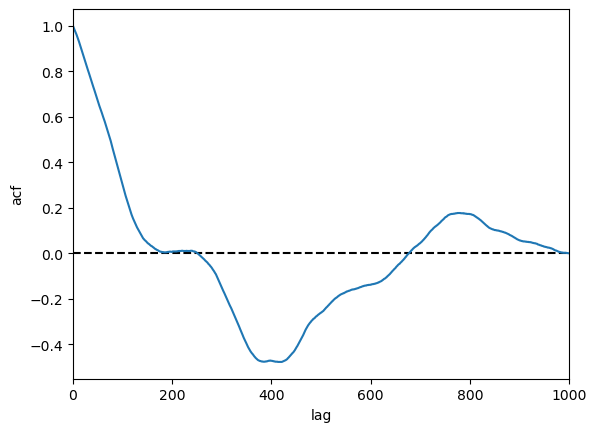

In [13]:
# walk_binary, walk_gaussian, ar1_series, ar, ar2
series_to_plot = walk_binary
fig, ax = plt.subplots()
lags, acf = compute_acf(series_to_plot)
ax.plot([0, n], [0]*2, color="black", ls="--")
ax.plot(lags, acf)
ax.set(xlabel="lag",
       ylabel="acf",
       xlim=[0, n]);

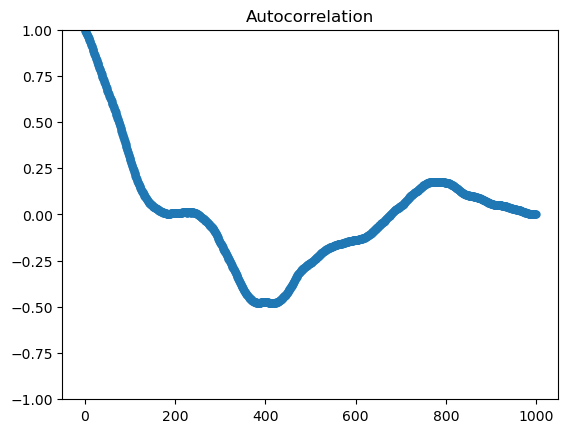

In [14]:
fig, ax = plt.subplots()
sm.graphics.tsa.plot_acf(series_to_plot, lags= n-1, ax=ax, label="statsmodels", alpha=None, use_vlines=False);

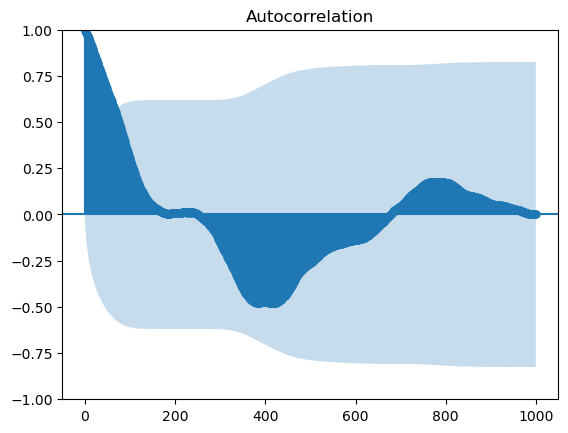

In [15]:
fig, ax = plt.subplots()
sm.graphics.tsa.plot_acf(series_to_plot, lags= n-1, ax=ax, alpha=.05);

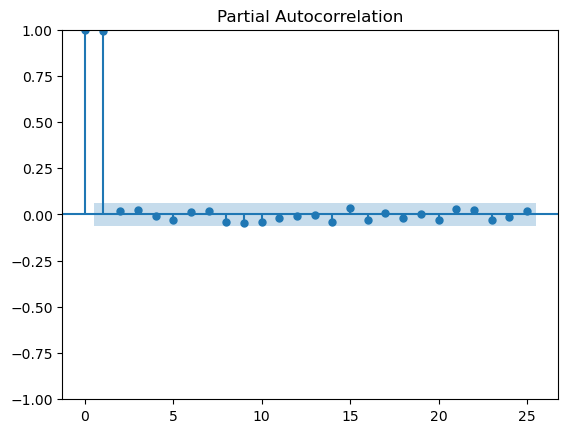

In [16]:
fig, ax = plt.subplots()
sm.graphics.tsa.plot_pacf(series_to_plot, lags=25, ax=ax, alpha=.05);


## Now let's work with actual data

In [17]:
filename = "jerusalem2019.csv"
filename = "co2_mm_mlo.csv"
df = pd.read_csv(filename, comment='#')
df['date'] = pd.to_datetime(df['month'].astype(str) + ' ' + df['year'].astype(str))
df = df.set_index('date')
df

/var/folders/wn/2bz1970d2w5182zy7h96yfcc0000gn/T/ipykernel_54211/3919485795.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['month'].astype(str) + ' ' + df['year'].astype(str))


,year,month,decimal date,average,deseasonalized,ndays,sdev,unc
date,,,,,,,,
1958-03-01,1958,3,1958.2027,315.71,314.44,-1,-9.99,-0.99
1958-04-01,1958,4,1958.2877,317.45,315.16,-1,-9.99,-0.99
1958-05-01,1958,5,1958.3699,317.51,314.69,-1,-9.99,-0.99
1958-06-01,1958,6,1958.4548,317.27,315.15,-1,-9.99,-0.99
1958-07-01,1958,7,1958.5370,315.87,315.20,-1,-9.99,-0.99
...,...,...,...,...,...,...,...,...
2024-06-01,2024,6,2024.4583,426.91,424.47,20,0.65,0.28
2024-07-01,2024,7,2024.5417,425.55,425.10,24,0.69,0.27
2024-08-01,2024,8,2024.6250,422.99,424.82,22,1.08,0.44


315.37

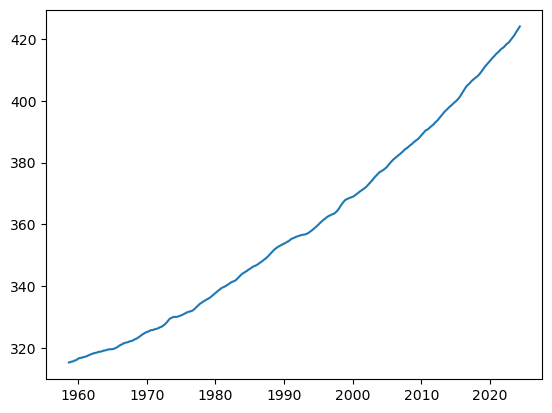

In [18]:
series = df['average'].rolling(window=12, center=True, min_periods=12).mean()
series = series.dropna()
series_np = series.values
fig, ax = plt.subplots()
ax.plot(series)
# ax.plot(df['average'])
# ax.plot((series2.cumsum() + series1[0]).cumsum()+first_ppm_recorded)
first_ppm_recorded = series.iloc[0]
first_ppm_recorded

In [19]:
series.diff(periods=-1)

date
1958-09-01   -0.078333
1958-10-01   -0.022500
1958-11-01   -0.065000
1958-12-01   -0.073333
1959-01-01   -0.055833
                ...   
2024-01-01   -0.310000
2024-02-01   -0.275833
2024-03-01   -0.294167
2024-04-01   -0.296667
2024-05-01         NaN
Name: average, Length: 789, dtype: float64

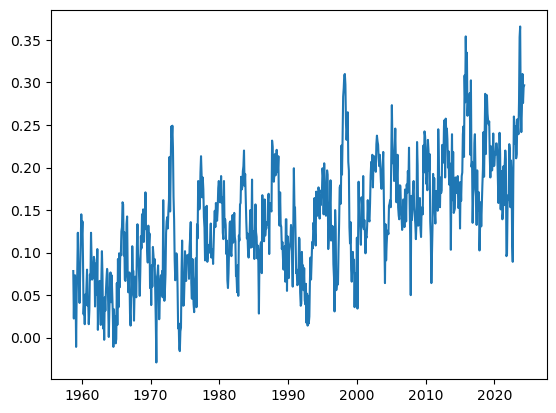

In [20]:
series1 = series.diff()
series_np = series.values
fig, ax = plt.subplots()
ax.plot(series1)

# ax.plot(series2.cumsum()+series1[0])

In [21]:
series1.cumsum()

date
1958-09-01           NaN
1958-10-01      0.078333
1958-11-01      0.100833
1958-12-01      0.165833
1959-01-01      0.239167
                 ...    
2024-01-01    107.480000
2024-02-01    107.790000
2024-03-01    108.065833
2024-04-01    108.360000
2024-05-01    108.656667
Name: average, Length: 789, dtype: float64

In [22]:
def integrate(series, first_value):
    reconst = series.cumsum()
    reconst[0] = 0
    return (reconst + first_value)

/var/folders/wn/2bz1970d2w5182zy7h96yfcc0000gn/T/ipykernel_54211/2153033442.py:3: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  reconst[0] = 0


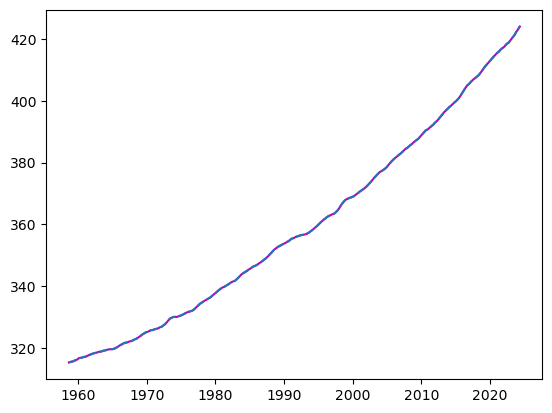

In [23]:
fig, ax = plt.subplots()
ax.plot(integrate(series1, first_ppm_recorded), c='m')
# ax.plot(series1.cumsum()+first_ppm_recorded)
ax.plot(series, ls='--')

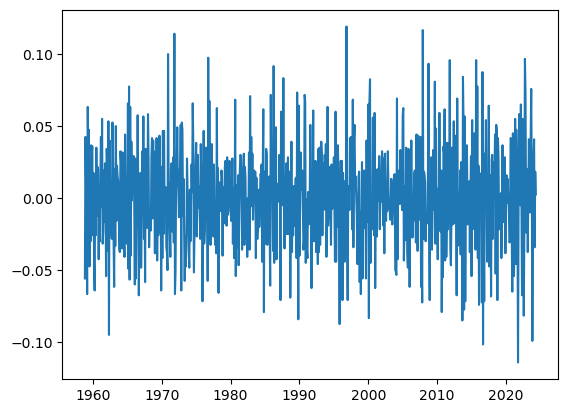

In [24]:
series2 = series1.diff()
series_np = series2.values
fig, ax = plt.subplots()
ax.plot(series2)

In [25]:
def integrate(series, first_value):
    # Check the type of input
    is_series = isinstance(series, pd.Series)
    
    # Convert numpy array to pandas Series for processing
    if not is_series:
        series = pd.Series(series)
    
    # Perform cumulative sum and adjustment
    reconst = series.cumsum()
    reconst.iloc[0] = 0
    reconst += first_value
    
    # Return the result as the same type as the input
    return reconst if is_series else reconst.to_numpy()

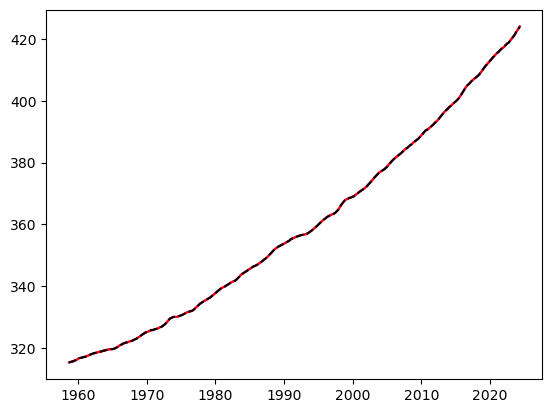

In [26]:
fig, ax = plt.subplots()
reconstructed1 = integrate(series1, series[series.first_valid_index()])
reconstructed2 = integrate(integrate(series2, series1[series1.first_valid_index()]), first_ppm_recorded)

ax.plot(reconstructed1, c='m')
ax.plot(reconstructed2, c='r')
ax.plot(series, c='k', ls='--')

In [27]:
series2_clean = series2[2:] # we skip the first two NaN values
series1_clean = series1[1:] # we skip the first NaN value

In [28]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(series2_clean) # must be without nanas

print("ADF Statistic:", result[0])
print("p-value:", result[1])
if result[1] < 0.05:
    print("The series is stationary.")
else:
    print("The series is not stationary. Differencing is needed.")


ADF Statistic: -11.337942249877967
p-value: 1.0721230892309654e-20
The series is stationary.


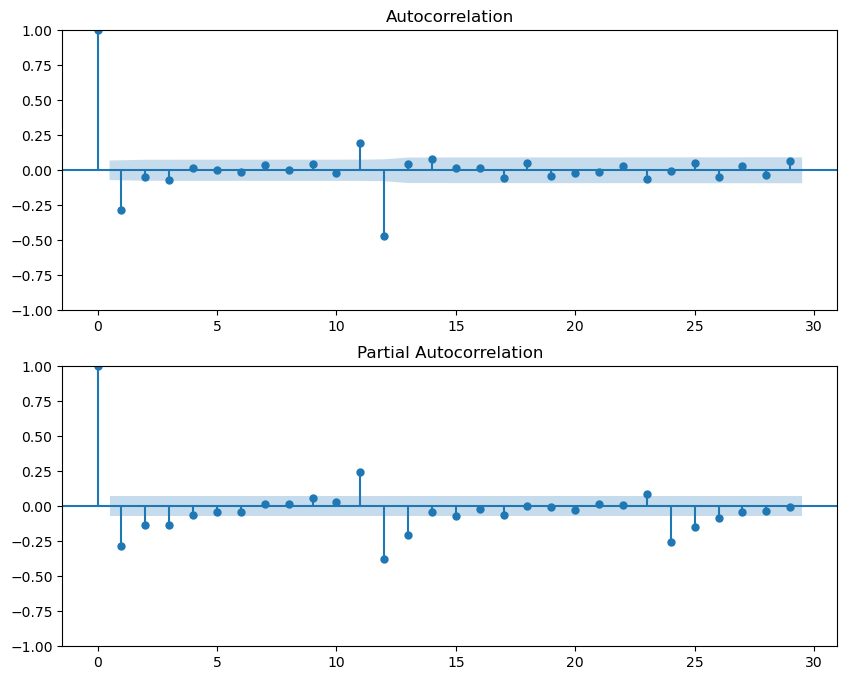

In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(series2_clean, ax=ax[0])
plot_pacf(series2_clean, ax=ax[1])
plt.show()


In [30]:
from pmdarima import auto_arima

# Fit auto-ARIMA to find the best (p, d, q)
model = auto_arima(series, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
# try again with series1 and series2

print(model.summary())

# Use the recommended order
order = model.order

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-3057.034, Time=0.39 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-2967.319, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-3030.622, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-3053.037, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-2969.274, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-3058.503, Time=0.13 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-3058.777, Time=0.17 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=-3059.752, Time=0.15 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=-3058.012, Time=0.13 sec
 ARIMA(0,2,4)(0,0,0)[0] intercept   : AIC=-3058.251, Time=0.17 sec
 ARIMA(1,2,4)(0,0,0)[0] intercept   : AIC=-3056.365, Time=0.47 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=-3061.530, Time=0.08 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-3060.588, Time=0.07 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=-3059.800, Time=0.06 sec
 ARIMA(0,2,4)(0,0,0

In [31]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model with correct order
model = ARIMA(series2_clean, order=(0,0,3))  # Replace 'order' with (p, d, q)
results = model.fit()
print(results.summary())

# Extract AR coefficients
ar_coeff = [1] + list(-results.arparams)  # Include 1 for ARIMA polynomial standard
ma_coeff = list(results.maparams)   
residual_std = np.std(results.resid)  
print("Fitted AR Coefficients:", ar_coeff)


                               SARIMAX Results                                
Dep. Variable:                average   No. Observations:                  787
Model:                 ARIMA(0, 0, 3)   Log Likelihood                1534.876
Date:                Tue, 03 Dec 2024   AIC                          -3059.752
Time:                        10:45:22   BIC                          -3036.411
Sample:                    11-01-1958   HQIC                         -3050.778
                         - 05-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.454      0.650      -0.001       0.002
ma.L1         -0.3495      0.034    -10.191      0.000      -0.417      -0.282
ma.L2         -0.0727      0.034     -2.125      0.0

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


/var/folders/wn/2bz1970d2w5182zy7h96yfcc0000gn/T/ipykernel_54211/2253271819.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_point = series[-1]
/var/folders/wn/2bz1970d2w5182zy7h96yfcc0000gn/T/ipykernel_54211/2253271819.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot(series[-1] + forecast_values.cumsum().cumsum(), label='Forecast', color='red', linestyle='--')


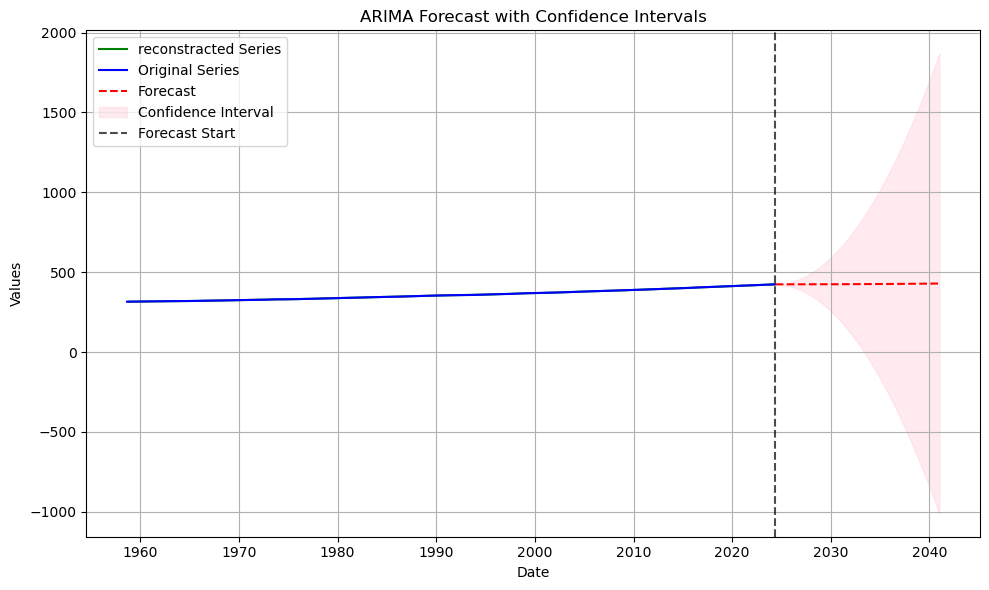

In [32]:
# Number of steps to forecast
steps = 200

# Forecast future values
forecast = results.get_forecast(steps=steps)
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()



# Create a new index for the forecast
forecast_index = pd.date_range(
    start=series.index[-1], 
    periods=steps + 1,  # +1 to include the start point
    freq=pd.infer_freq(series.index)
)[1:]  # Exclude the start point

# Align forecast with the index
forecast_values.index = forecast_index
confidence_intervals.index = forecast_index


fig, ax = plt.subplots(figsize=(10, 6))

last_point = series[-1]
first_ppm_recorded = series.iloc[0]

# Plot original series
ax.plot(reconstructed2, label='reconstracted Series', color='green')
ax.plot(series, label='Original Series', color='blue')

# Plot forecast
ax.plot(series[-1] + forecast_values.cumsum().cumsum(), label='Forecast', color='red', linestyle='--')


# Add confidence intervals
ax.fill_between(
    forecast_index,
    last_point + confidence_intervals.cumsum().cumsum().iloc[:, 0],
    last_point + confidence_intervals.cumsum().cumsum().iloc[:, 1],
    color='pink',
    alpha=0.3,
    label='Confidence Interval'
)


# Highlight visual continuity with dashed lines
ax.axvline(series.index[-1], color='black', linestyle='--', alpha=0.7, label='Forecast Start')

# Add labels, legend, and grid
ax.set_title('ARIMA Forecast with Confidence Intervals')
ax.set_xlabel('Date')
ax.set_ylabel('Values')
ax.legend(loc='upper left')
ax.grid()

fig.tight_layout()
plt.show()


In [33]:
ma_coeff

[-0.3495294478282093, -0.07269624580059555, -0.06203261498192508]

In [34]:
# Forecasting function using ARIMA coefficients
def arma_forecast(series, ar_coeff, ma_coeff, noise_scale=residual_std):
    s = series.copy()
    phi = -np.array(ar_coeff[1:])  # AR coefficients
    theta = np.array(ma_coeff)     # MA coefficients
    theta = np.array([0])
    # start_index = np.argmax(np.isnan(s))  # Start forecasting at first NaN
    start_index = np.where(np.isnan(s))[0]
    start_index = start_index[start_index > np.argmax(~np.isnan(s))][0]
    # print(start_index)
    noise = np.random.normal(scale=noise_scale, size=len(series))  # Random noise for MA component

    # Forecast ARMA process
    for i in range(start_index, len(series)):
        # AR component
        ar_term = sum(phi[j] * s[i - j - 1] for j in range(len(phi)) if i - j - 1 >= 0)
        # MA component
        ma_term = sum(theta[j] * noise[i - j - 1] for j in range(len(theta)) if i - j - 1 >= 0)
        # Combine AR, MA, and noise
        s[i] = ar_term + ma_term + noise[i]
    return s

arima_220_diff2 = series2.values
original_series = series.values

l = 500
missing = series2.values
missing[l:] = np.nan

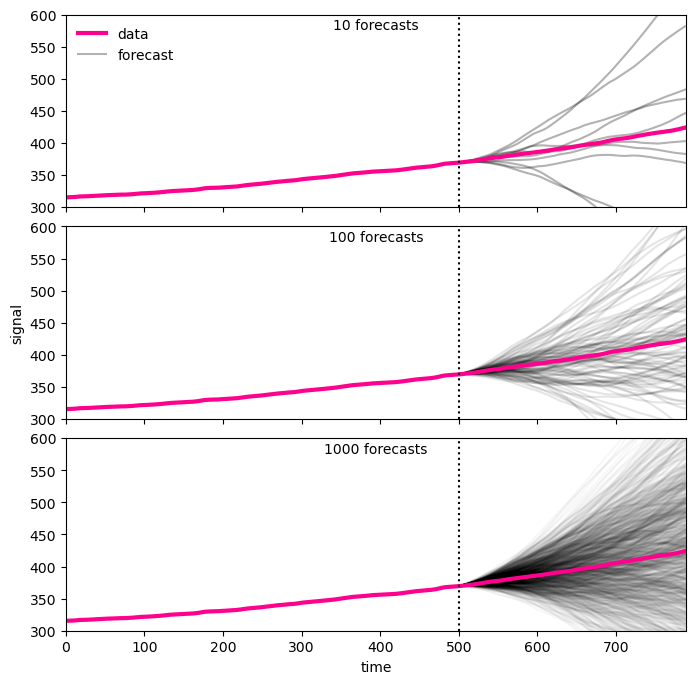

In [35]:
fig, axes = plt.subplots(3, 1, figsize=(8, 8))
fig.subplots_adjust(hspace=0.1)

xlim = [0, len(missing)]
ylim = [300,600]

ax0 = axes[0]
ntries = 10
for i in range(ntries):
    np.random.seed(i)
    try_diff = arma_forecast(missing, ar_coeff=ar_coeff, ma_coeff=ma_coeff)
    t = np.nancumsum(np.nancumsum(try_diff)+series1[series1.first_valid_index()]) + first_ppm_recorded
    # t = np.cumsum(np.cumsum(try_diff)+series1[0]) + first_ppm_recorded
    ax0.plot(t, color="black", alpha=0.3)
ax0.plot(original_series, color="xkcd:hot pink", lw=3, label="data")
ax0.plot([len(missing),len(missing)+1], [0]*2, color="black", alpha=0.3, label="forecast")
ax0.set(xticklabels=[],
        xlim=xlim,
        ylim=ylim)
ax0.text(0.5, 0.98, f"{ntries} forecasts",
         transform=ax0.transAxes, ha="center", va="top")
ax0.legend(frameon=False)
ax0.plot([l]*2, ylim, color="black", ls=":")

ax1 = axes[1]
ntries = 100
for i in range(ntries):
    np.random.seed(i)
    try_diff = arma_forecast(missing, ar_coeff=ar_coeff, ma_coeff=ma_coeff)
    t = np.nancumsum(np.nancumsum(try_diff)+series1[series1.first_valid_index()]) + first_ppm_recorded
    ax1.plot(t, color="black", alpha=0.1)
ax1.plot(original_series, color="xkcd:hot pink", lw=3)
ax1.set(xticklabels=[],
        ylabel="signal",
        xlim=xlim,
        ylim=ylim)
ax1.text(0.5, 0.98, f"{ntries} forecasts",
         transform=ax1.transAxes, ha="center", va="top")
ax1.plot([l]*2, ylim, color="black", ls=":")


ax2 = axes[2]
ntries = 1000
for i in range(ntries):
    np.random.seed(i)
    try_diff = arma_forecast(missing, ar_coeff=ar_coeff, ma_coeff=ma_coeff)
    t = np.nancumsum(np.nancumsum(try_diff)+series1[series1.first_valid_index()]) + first_ppm_recorded
    ax2.plot(t, color="black", alpha=0.03)
ax2.plot(original_series, color="xkcd:hot pink", lw=3)
ax2.set(xlabel='time',
        xlim=xlim,
        ylim=ylim)
ax2.text(0.5, 0.98, f"{ntries} forecasts",
         transform=ax2.transAxes, ha="center", va="top")
ax2.plot([l]*2, ylim, color="black", ls=":")